# PyTorch Workflow

Ground truth notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb

In [1]:
what_were_covering = {
    1: "data",
    2: "build_model",
    3: "training",
    4: "inference",
    5: "save_and_load",
    6: "combine"
}
what_were_covering

{1: 'data',
 2: 'build_model',
 3: 'training',
 4: 'inference',
 5: 'save_and_load',
 6: 'combine'}

In [2]:
import torch
from torch import nn # main lib for nn
import matplotlib.pyplot as plt

torch.__version__

'2.1.0+cu121'

## 1. Data (preparing and loading)

In [3]:
# generate data with regression

weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [4]:
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
X.shape

torch.Size([50, 1])

### Splitting data into training and test

In [6]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

### Func to visualize data

In [7]:
def plot_predictions(
        train_data=X_train,
        train_labels=y_train,
        test_data=X_test,
        test_labels=y_test,
        predictions=None
):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c='b', s=4, label='training data')

    plt.scatter(test_data, test_labels, c='g', s=4, label='testing data')

    if predictions:
        plt.scatter(test_data, predictions, c='r', s=4, label='predictions')

    plt.legend(prop={"size": 14})

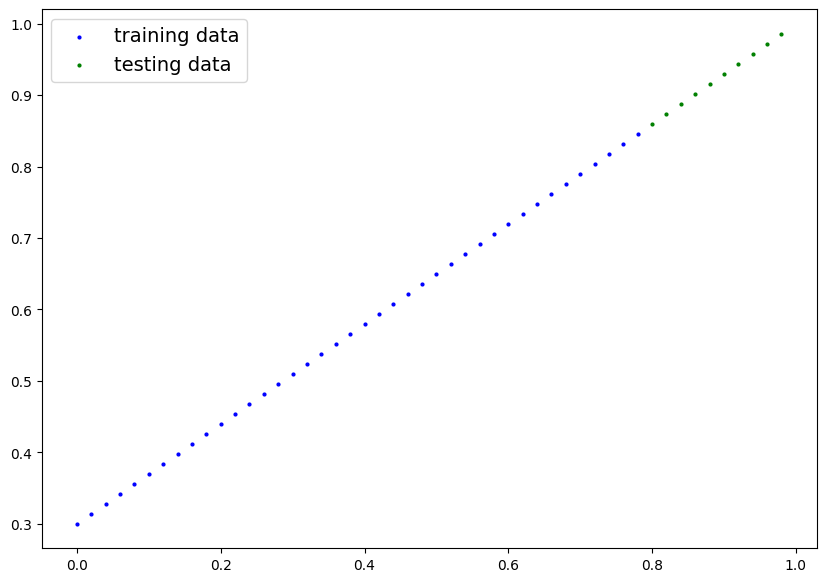

In [8]:
plot_predictions()

## 2. Building model

In [9]:
model = nn.Linear(
    in_features=1,
    out_features=1,
)
model.weight

Parameter containing:
tensor([[-0.7783]], requires_grad=True)

In [11]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(1,
                        requires_grad=True,
                        dtype=torch.float
                        )
        )
        self.bias = nn.Parameter(
            torch.randn(1,
                        requires_grad=True,
                        dtype=torch.float
                        )
        )

    # forward method to define computtaion in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias


### PyTorch model building essentials

* torch.nn - contains all of the building for computational graphs
* torch.nn.Parameter - model parameters
* torch.nn.Module - base class for all nn modules
* torch.optim - where torch optimizeres live
* def forward(X) - All nn.Module subclasses require you to overr|ide forward



### Checking the contents of PyTorch model

In [12]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [13]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [14]:
weight, bias

(0.7, 0.3)

### Initial predictions

In [15]:
# init_preds = model_0(X_test).detach().tolist()
# plot_predictions(predictions=init_preds)

In [16]:
# new thing here, after no_grad
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

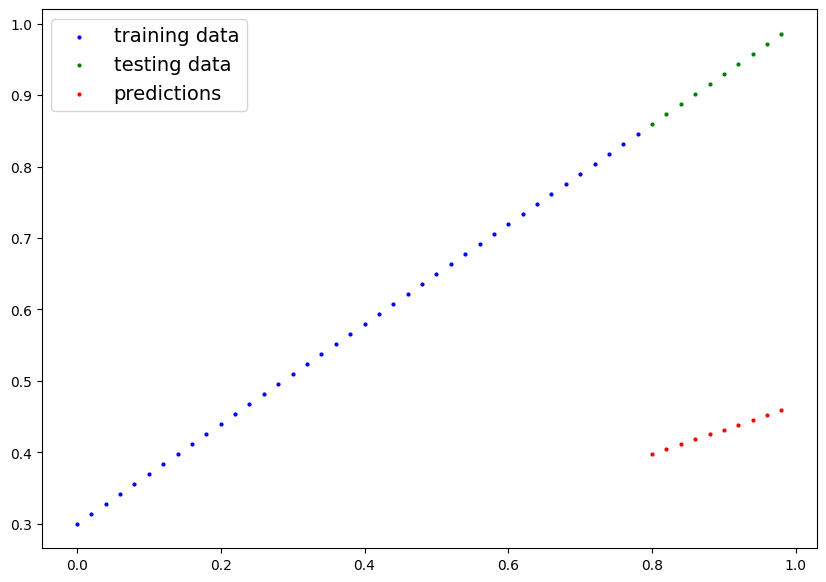

In [17]:
plot_predictions(predictions=y_preds.tolist())

## 3. Training

**loss functions Measure how poor your models predixtion are


In [18]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [19]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [23]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Choose an optimizer
opt = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.01,
)

### Training and testing loop

A things we need in a training loop:
0. Loop throught the data
1. Forward pass (inputs -> outputs), propagation
2. Calculate the loss
3. optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of parameters
5. Optimizier step (**gradient descent**)


In [24]:
torch.manual_seed(42)
# epoch  - one loop through the data
epochs = 200


# Tracking experiment
epoch_count = []
loss_values = []
test_loss_values = []

# 0.
for epoch in range(epochs):
    # Set the model to training. mode
    model_0.train() # train mode set all params the require gradients to require gradients

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculating loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad
    opt.zero_grad() #

    # 4. Backprop
    loss.backward()

    # 5. Perform grad descent
    opt.step() # we have to zero them above in step 3 for the next iteration of the loop

    ### Testing
    model_0.eval() # turns off different settings in the model not needed for evaluating/testing (like dropuor or batch_norm layers)
    with torch.inference_mode(): # turns off gradient tracking
        # 1. Apply model on test
        test_pred = model_0(X_test)

        # 2. Calculate loss
        test_loss = loss_fn(test_pred, y_test)

    ### Tracking
    if epoch % 10 == 0:
        # Add track
        epoch_count.append(epoch)
        loss_values.append(loss.item())
        test_loss_values.append(test_loss.item())
        print(f"Epoch={epoch}; Training MAE loss={loss.item():0.4f}; Test MAE loss={test_loss.item():0.4f}")


Epoch=0; Training MAE loss=0.0553; Test MAE loss=0.0270
Epoch=10; Training MAE loss=0.0077; Test MAE loss=0.0171
Epoch=20; Training MAE loss=0.0042; Test MAE loss=0.0088
Epoch=30; Training MAE loss=0.0075; Test MAE loss=0.0016
Epoch=40; Training MAE loss=0.0075; Test MAE loss=0.0016
Epoch=50; Training MAE loss=0.0075; Test MAE loss=0.0016
Epoch=60; Training MAE loss=0.0075; Test MAE loss=0.0016
Epoch=70; Training MAE loss=0.0075; Test MAE loss=0.0016
Epoch=80; Training MAE loss=0.0075; Test MAE loss=0.0016
Epoch=90; Training MAE loss=0.0075; Test MAE loss=0.0016
Epoch=100; Training MAE loss=0.0075; Test MAE loss=0.0016
Epoch=110; Training MAE loss=0.0075; Test MAE loss=0.0016
Epoch=120; Training MAE loss=0.0075; Test MAE loss=0.0016
Epoch=130; Training MAE loss=0.0075; Test MAE loss=0.0016
Epoch=140; Training MAE loss=0.0075; Test MAE loss=0.0016
Epoch=150; Training MAE loss=0.0075; Test MAE loss=0.0016
Epoch=160; Training MAE loss=0.0075; Test MAE loss=0.0016
Epoch=170; Training MAE l

Text(0.5, 0, 'Epochs')

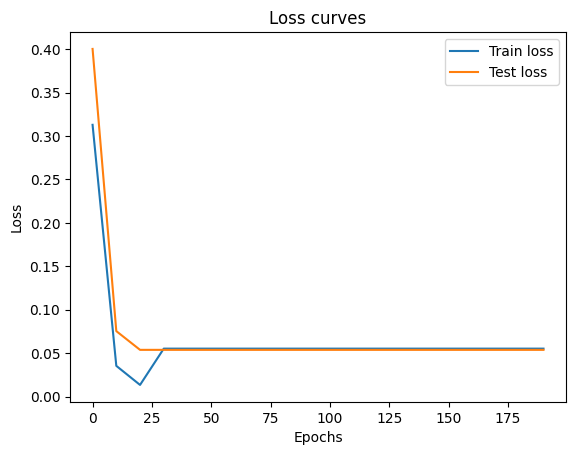

In [22]:
plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.legend()
plt.title('Loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')

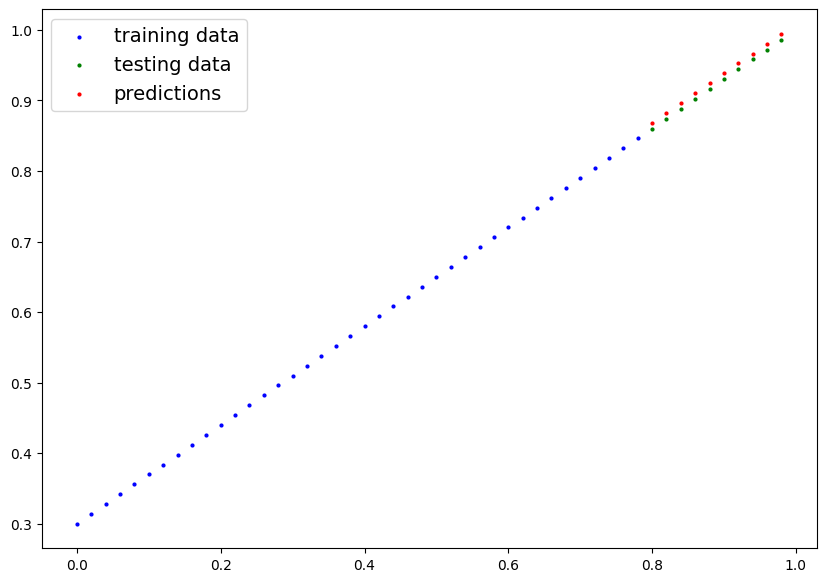

In [56]:
with torch.inference_mode():
    y_preds = model_0(X_test)
plot_predictions(predictions=y_preds.tolist())

In [48]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

## 5. Saving and loading the model

3 main methods:

1. `torch.save()` in Python pickle format
2. `torch.load()` load a saved model object
3. `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dict

In [33]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [35]:
# Saving
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save state dict
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [37]:
!ls models

01_pytorch_workflow_model_0.pth


In [38]:
# New class for state dict
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(
    torch.load(f=MODEL_SAVE_PATH)
)

<All keys matched successfully>

In [39]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [40]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_preds = loaded_model_0(X_test)

loaded_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [45]:
model_0.eval()
with torch.inference_mode():
    y_pred = model_0(X_test)

y_pred == loaded_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plr

In [8]:
device = "cuda" if torch.cuda.is_available() > 0 else "cpu"
print("Using device = ", device)

Using device =  cuda


### 6.1 Data

In [ ]:
# Create some data using the linear regression
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

In [5]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [6]:
torch.manual_seed(42)

model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [9]:
model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [12]:
next(model_1.parameters()).device

device(type='cuda', index=0)